In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
import time
from IPython import display
from tensorflow import keras
from tensorflow.keras import layers
tf.__version__

'2.12.0'

In [ ]:
(X_train, Y_train), (_, _) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
X_train.shape, Y_train.shape

((60000, 28, 28), (60000,))

In [ ]:
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')

In [ ]:
X_train.shape

(60000, 28, 28, 1)

In [ ]:
X_train = (X_train - 127.5) / 127.5

In [ ]:
buffer_size = 60000
batch_size = 256

In [ ]:
X_train = tf.data.Dataset.from_tensor_slices(X_train).shuffle(buffer_size).batch(batch_size)

In [ ]:
def build_generator():
  model = tf.keras.Sequential()

  model.add(layers.Dense(units = 7 * 7 * 256, use_bias = False, input_shape = (100,)))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Reshape((7,7,256)))

  #7 * 7 * 128
  model.add(layers.Conv2DTranspose(filters = 128, kernel_size = (5,5), padding = 'same', use_bias = False))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  # 7 * 7 * 64
  model.add(layers.Conv2DTranspose(filters = 64, kernel_size = (5,5), padding = 'same', strides = (2,2), use_bias = False))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  # 7 * 7 * 1
  model.add(layers.Conv2DTranspose(filters = 1, kernel_size = (5,5), padding = 'same', strides = (2,2), use_bias = False))

  model.summary()

  return model

In [ ]:
generator = build_generator()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 batch_normalization (BatchN  (None, 12544)            50176     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 128)        5

In [ ]:
noise = tf.random.normal([1, 100])
noise

<tf.Tensor: shape=(1, 100), dtype=float32, numpy=
array([[ 0.9208051 , -1.5336249 , -1.0614249 ,  1.3731699 ,  1.7653219 ,
        -1.9480726 ,  0.6169628 , -0.20461734, -0.49252185,  0.5512971 ,
        -1.0128504 ,  0.4402495 ,  1.9706542 ,  2.2041981 ,  0.63999325,
        -0.89874315, -0.03591022,  0.67737114, -1.0397496 , -0.53955555,
        -0.16447492, -0.29900414,  0.8476208 , -0.16145398, -0.2656143 ,
         1.89615   , -1.9882418 , -0.01766389, -1.3035864 , -0.4539705 ,
         0.8121607 ,  0.4124056 ,  0.15596351, -1.3417232 , -1.0216612 ,
         0.75897115,  1.1246344 , -0.04195414, -0.77519006,  0.27667135,
        -1.9558412 , -0.03335175,  0.22500038, -1.2202593 , -0.8022686 ,
         0.5332757 , -0.7319838 ,  0.61095953,  0.34504396, -1.5527264 ,
        -0.7680536 ,  0.3689463 ,  0.9689615 ,  0.8597065 , -0.58369535,
         0.15569687, -1.0793598 ,  1.8954216 , -1.3525183 , -1.1104549 ,
         0.72701806,  1.690411  , -0.16977797,  0.201595  , -0.02757328,
 

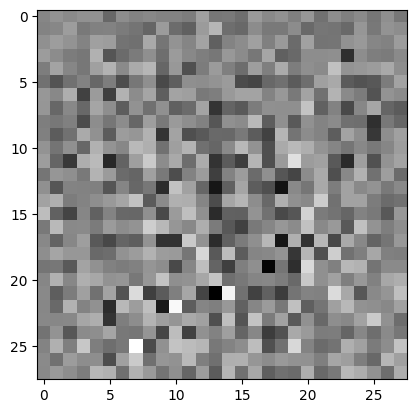

In [ ]:
generated_images = generator(noise, training = False)
plt.imshow(generated_images[0,:,:,0], cmap = 'gray')

In [ ]:
def build_discriminator():
  model = tf.keras.Sequential()

  # 14 * 14 * 64
  model.add(layers.Conv2D(filters = 64, strides = (2,2), kernel_size = (5,5), padding = 'same', input_shape = [28, 28, 1]))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  # 7 * 7 * 128
  model.add(layers.Conv2D(filters = 128, strides = (2,2), kernel_size = (5,5), padding = 'same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Flatten())
  model.add(layers.Dense(1))

  model.summary()

  return model

In [ ]:
discriminator = build_discriminator()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)             

In [ ]:
discriminator(generated_images, training = False) # logits

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00092838]], dtype=float32)>

In [ ]:
tf.sigmoid(0.0005862)

<tf.Tensor: shape=(), dtype=float32, numpy=0.50014657>

In [ ]:
def gen_loss(fake_output):
  g_loss = -1 * tf.math.reduce_mean(fake_output)
  return g_loss

In [ ]:
def dic_loss(real_output, fake_output, gradiant_penalty):
  c_lambda = 10
  d_loss = tf.math.reduce_mean(fake_output) - tf.math.reduce_mean(real_output) + c_lambda * gradiant_penalty
  return d_loss

In [ ]:
@tf.function
def gradiant_penalty(real, fake, epsilon):
  interpolated_images = real * epsilon + fake * (1 - epsilon)
  with tf.GradientTape() as tape:
    tape.watch(interpolated_images)
    scores = discriminator(interpolated_images)[0]
  gradient = tape.gradient(scores, interpolated_images)[0]
  gradient_norm = tf.norm(gradient)
  gp = tf.math.reduce_mean((gradient_norm - 1) ** 2)
  return gp

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0002, beta_1 = 0.5, beta_2 = 0.9)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0002, beta_1 = 0.5, beta_2 = 0.9)

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'checkpoints')
checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer,
                                 discriminator_optimizer = discriminator_optimizer,
                                 generator = generator,
                                 discriminator = discriminator)

In [ ]:
epochs = 30
noise_dim = 100
number_of_images = 16
seed = tf.random.normal([number_of_images, noise_dim])

In [ ]:
seed

<tf.Tensor: shape=(16, 100), dtype=float32, numpy=
array([[-2.2190912 ,  0.5824624 , -1.6092398 , ..., -0.04384303,
        -0.53928375,  0.27477604],
       [-0.84774846, -0.67876023,  1.0943457 , ...,  1.0754707 ,
         0.37908825, -0.41597953],
       [-0.00669388,  0.1228615 ,  1.5665514 , ...,  0.25152603,
        -0.07462737,  0.14400019],
       ...,
       [ 0.40561524,  0.9452119 ,  0.2561679 , ..., -1.003557  ,
         1.4987609 ,  0.15873483],
       [ 0.8306257 ,  1.4209526 ,  1.9992073 , ..., -0.7192331 ,
        -0.9214866 ,  0.30880308],
       [ 1.365792  , -1.1968764 ,  2.1845198 , ..., -0.94869035,
        -0.37264544,  0.25800863]], dtype=float32)>

In [ ]:
def trainig_step(images):
  noise = tf.random.normal([batch_size, noise_dim])
  discriminator_extra_steps = 3
  for i in range(discriminator_extra_steps):
    with tf.GradientTape() as d_tape:
      generadet_images = generator(noise, training = True)
      real_output = discriminator(images, training = True)
      fake_output = discriminator(generadet_images, training = True)
      epsilon = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
      gp = gradiant_penalty(images, generadet_images, epsilon)

      d_loss = dic_loss(real_output, fake_output, gp)
    discriminator_gradients = d_tape.gradient(d_loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

    with tf.GradientTape() as g_tape:
      generated_image = generator(noise, training = True)
      fake_out = discriminator(generated_image, training = True)
      g_loss = gen_loss(fake_out)
    generator_gradients = g_tape.gradient(g_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))

In [ ]:
def crear_and_save_image(model, epoch, test_input):
  preds = model(test_input, training = False)
  fig = plt.figure(figsize = (4,4))
  for i in range(preds.shape[0]):
    plt.subplot(4,4,i + 1)
    plt.imshow(preds[i, :, :, 0] * 127.5 + 127.5, cmap = 'gray')
    plt.axis('off')
    plt.savefig('img_epoch_{:04d}'.format(epoch))
    plt.show()

In [ ]:
def train(datasets, epochs):
  for epoch in range(epochs):
    initial = time.time()
    for img_batch in datasets:
      if len(img_batch) == batch_size:
        trainig_step(img_batch)
    display.clear_output(wait = True)
    crear_and_save_image(generator, epoch + 1, seed)
    if (epoch + 1) % 10 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
    print('Time taken to process epoch {} was {} secend'.format(epoch + 1, time.time() - initial))

  display.clear_output(wait = True)
  crear_and_save_image(generator, epoch, seed)
  generator.sace('generator.h5')

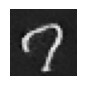

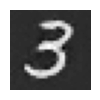

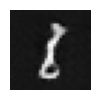

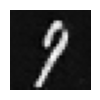

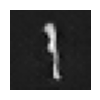

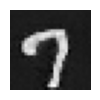

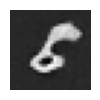

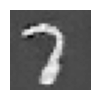

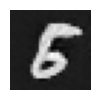

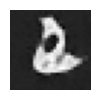

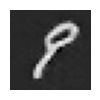

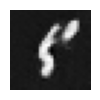

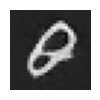

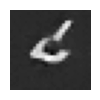

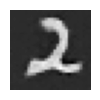

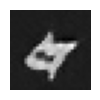

AttributeError: ignored

In [ ]:
train(X_train, epochs)

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
seed_input = tf.random.normal([number_of_images, noise_dim])
preds = generator(seed_input, trainig = False)
fig = plt.figure(figsize = (4,4))
for i in range(preds.shape[0]):
  plt.subplot(4,4,i+1)
  plt.imshow(preds[i, :, :,0] * 127.5 * 127.5, cmap = 'gray')
  plt.axis('off')